### Complete Example of developing a CNN application including saving the model and predicting on new data ###

In [1]:
'''Import standard modules for data processing and visualization'''
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

'''Import all the required torch modules'''
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.dataset import random_split
import torchvision.transforms as transforms

'''Import all the required torch summery module for model summary'''
from torchsummary import summary  # pip install torchsummary

'''For checking if path to image is correct path'''
import os

'''Import skimage modules for saving, manupulating, and reading images'''
from skimage.io import imsave, imread
from skimage import io,transform
from skimage.color import rgb2gray

'''Import warnings module to ignore warnings'''
import warnings
warnings.filterwarnings('ignore')

'''Set manual seed for the torch randomly generated parameters to have same values'''
torch.manual_seed(1)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Check if CPU is available

In [13]:
# Which is the root directory in which my image files located?

img_path = 'Mnist_Image_Data/Images'

In [14]:
# Which directories are there in the img path which contain my inages?

for root, dirs, files in os.walk(img_path, topdown=False):
        for name in dirs:
              print(os.path.join(root, name))
              

Mnist_Image_Data/Images/test
Mnist_Image_Data/Images/train


In [16]:
# Read in the train and test labels from .csv files

train_labels =  pd.read_csv('Mnist_Image_Data/train.csv') # Read in the train labels

test_labels =  pd.read_csv('Mnist_Image_Data/test.csv') # Read in the test labels

print(f"Label file contains image filename and the corresponding label:\n\n{train_labels.head()}\n") # Display the first 5 rows of the train labels


Label file contains image filename and the corresponding label:

  filename  label
0    0.png      4
1    1.png      9
2    2.png      1
3    3.png      7
4    4.png      3



Image filename:
Mnist_Image_Data/Images/train/0.png

Image Shape(28, 28, 4)

Single channel image shape: (28, 28, 1)


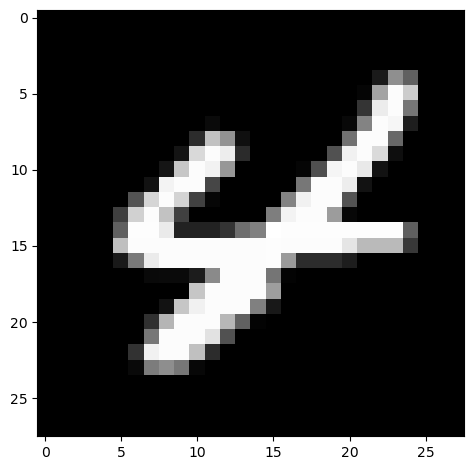

In [17]:
# Let us check a single image file using the destination information
img = os.path.join(img_path+'/train/'+train_labels['filename'][0]) # use the image path and go into the train directory's train_label dataset and get the 0th item from the filename column
print(f"Image filename:\n{img}")

# Display image
img = plt.imread(img) # read the image
print(f"\nImage Shape{img.shape}") # read the image shape

# We need omly one channel as represntative of a image because they are 28x28x1 images
img =  img[:,:,:1] # get the first channel of the image
print(f"\nSingle channel image shape: {img.shape}") # Display the shape of the image

# Display the image
io.imshow(img) # Display the image
plt.show() # Show the image

In [18]:
# Create the dataset class to read in data by inheriting the PyTorch Dataset class
# The dataset class should return 1 datapoint as a tuple - an image and its label

class mnist(Dataset): # inherit from parent dataset class of PyTorch

    def __init__(self, img_path,labels,transforms=None): # read the image path, labels file and the transforms to be applied
        self.img_path = img_path # store the image path
        self.labels = labels # store the labels file (test or train labels files)
        self.transforms = transforms # if there are any transforms to be applied
        

    def __len__(self): # get the length of the dataset
        return len(self.labels) # return the length of the labels file


    def __getitem__(self,idx): # get the item at the index

        img = os.path.join(self.img_path+self.labels['filename'][idx]) # get the image path
        img = io.imread(img) # read one image at a time
        
        img = img[:,:,:1] # Read a single channel only out of the 3 channels
    
        img = img/255.0   # Normalize or Feature Scale data
        img = np.moveaxis(img,2,0) # bring the 1 part of the 28x28x1 image to the front (pring position 2 to position 0)
        
        label = self.labels['label'][idx] # get the label of the image
        label = label.astype('float') # conver the label to float cause the model expects float values
        label = np.array(label).reshape(-1,1) # convert the label to a numpy array and reshape it to a single column
        
        if self.transforms is not None: # if there are any transforms to be applied
            img = self.transforms(img) # apply the transforms to the image
        
        return torch.from_numpy(img),torch.from_numpy(label) # return the image and the label as a torch tensor

In [19]:
# Instantiate the train and test data objects from the mnist class just created
train_data =  mnist(img_path+'/train/',train_labels) # instantiate the train data object
test_data =  mnist(img_path+'/test/',test_labels) # instantiate the test data object

# Amount of data - train and test while testing the __len__ method
print(train_data.__len__(),test_data.__len__()) # Display the length of the train and test data

49000 100


Image Shape as read in:torch.Size([1, 28, 28])
Image Type:<class 'torch.Tensor'>

The label for this image is: tensor([[9.]], dtype=torch.float64)

Image Shape after moving axis:(28, 28)
Label Shape:torch.Size([1, 1])



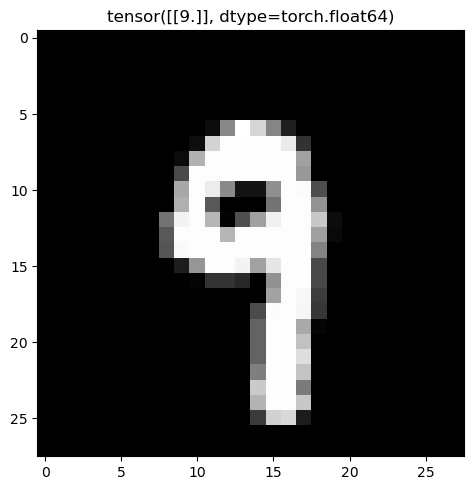

In [20]:
# Look at an image while testing the __getitem__ method

# Use "get item" method to get one data point from any index (idx = 1 in this example)
image1,label1 = train_data.__getitem__(1) # get the image and label at index 1
print(f"Image Shape as read in:{image1.shape}\nImage Type:{type(image1)}\n") # Display the shape of the image and the type of the image
print(f"The label for this image is: {label1}\n") # Display the label of the image

image1 = np.array(image1)        #1,28,28 and convert to numpy array
image1 = np.moveaxis(image1,0,2) #28,28,1 - move back to original shape
image1 = np.squeeze(image1)      #28,28 - move back to original form to display the image

print(f"Image Shape after moving axis:{image1.shape}\nLabel Shape:{label1.shape}\n") # Display the shape of the image and the label

io.imshow(image1) # Display the image
plt.title(label1) # Display the label as the title of the image
plt.show() # Show the image


In [21]:
# Dataloader to get mini batched of data

train_loader = DataLoader(dataset=train_data, batch_size=64,shuffle=False) # create the train loader
test_loader = DataLoader(dataset=test_data, batch_size=20,shuffle=False) # create the test loader


In [22]:
# let us check if the mini batch is being loaded everytime we call train loader

#next(iter(train_loader)) # one way to check if the data is being loaded correctly by checking the first batch of data is loaded correctly

for i , (x_batch,y_batch) in enumerate(train_loader): # another way to check if the data is being loaded correctly by getting key value pairs of the train loader as x_batch (image) and y_batch (label)
    break # break the loop after the first iteration

x_batch.shape,y_batch.shape # Display the shape of the image and the label

(torch.Size([64, 1, 28, 28]), torch.Size([64, 1, 1]))

In [23]:
# Build the CNN model architecture

class Net(nn.Module): # inherit from the super class nn.Module
    def __init__(self): # constructor of the class
        '''Order does not matter in the constructor'''
        super(Net, self).__init__() # inherit the super class constructor
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5,padding=2) # convolutional layer 1 (1 input channel because 28x28x1, generate 32 images because of 32 filters, filter size 5x5, padding is 2) 
        self.conv2 = nn.Conv2d(32,64, kernel_size=5,padding=2) # convolutional layer 2 (32 input channels, generate 64 images out of the 32 channels, filter size 5x5, padding is 2)
        self.dropout = nn.Dropout2d(p=0.2) # create a dropout layer with 20% probability of dropout
        self.conv3 = nn.Conv2d(64,128, kernel_size=5,padding=2) # convolutional layer 3 (64 input channels, generate 128 images out of the 64 channels, filter size 5x5, padding is 2).

        '''Now unravel the images so that we can feed the pixels to the fully connected layers - remember to completely determine the image size before connecting to the fully connected layers'''
        '''The amount of fully connected layers you choose depends on the accuracy of the model. If the accuracy is not good, you can add more fully connected layers to improve the accuracy'''
        self.fc1 = nn.Linear(7*7*128, 1000) # fully connected layer 1 (128 images of size 7x7, 1000 neurons). You have to figure out the 7x7 size by using the formula ((28 size + (2 padding * (2)) - 5 kernel size) / 1) + 1 = 28/2 = 14/2 = 7. If you get it wrong, the model will throw an error. This is a linear layer so you are taking in the 7x7x128 pixels and outputting 1000 neurons
        self.fc2 = nn.Linear(1000,50) # fully connected layer 2 (1000 neurons, 50 neurons)  - we drop from 1000 neurons to 50 neurons to reduce the number of parameters
        self.fc3 = nn.Linear(50, 10) # fully connected layer 3 (50 neurons, 10 neurons) - 10 neurons because we have 10 classes (0-9 digits)
        self.relu = nn.ReLU() # activation function
        self.maxpool = nn.MaxPool2d(2) # maxpooling layer with a kernel size of 2. Maxpooling reduces the size of the image by half

    def forward(self, x): # take in the input x (image) to build the foward network
        '''While we generated 3 convolutional layers, we only use 2 maxpooling layers in the forward network. This is so that if we run the model and the accuracy is not good, we can add the third maxpooling layer to see if the accuracy improves'''
        x = self.conv1(x) # feed it through convolutional layer 1 : ((28 size + (2 padding * (2)) - 5 kernel size) / 1) + 1 = 28
        x = self.relu(x) # apply the activation function
        x = self.maxpool(x) # apply maxpooling : 28/2 = 14
        
        x = self.conv2(x) # feed it through convolutional layer 2 : ((14 size + (2 padding * (2)) - 5 kernel size) / 1) + 1 = 14
        x = self.dropout(x) # apply dropout which does not affect the dimensions of the image
        x = self.relu(x) # apply the activation function
        x = self.maxpool(x) # apply maxpooling : 14/2 = 7
        
        x = self.relu(self.conv3(x)) # feed it through convolutional layer 3, apply the activation function : We are generating 128 images of size 7x7 in the final layer of the convolutional network
        
        '''Final images are 7x7x128 where 128 is the number of channels/pixels in the image'''

        x = x.view(-1, 7*7*128) # the pytorch equivalent of numpy's reshape function which reshapes the image to 1 row so it fits in the batch size of 64 images. There are a ton of columns: 7x7x128 columns/pixels
        
        x = self.relu(self.fc1(x)) # feed it through the fully connected layer 1 with activation function
        
        # Dropout will work only during training with that comment
        if self.training: # if the model is training mode
            x = self.dropout(x) # even though the later model.eval() will eliminate dropout, this is a good practice to show that dropout is only applied during training
        x = self.fc2(x) # feed it through the fully connected layer 2 without activation function (direct output)
        x = self.fc3(x) # feed it through the fully connected layer 3 without activation function (direct output)
        return x # return the output

In [24]:
# Print model summary

model = Net()   # Instantiate the model object out of the Net class
summary(model,(1,28,28)) # make sure the model is working by passing in the input shape of the image (1 batch size, 28x28 image). 1 channel is already specified in the Net class model.

'''
Tells you how you built the model:
    * the number of parameters in the model
    * the weights in every convolutional layer that need to get trained in the fully connected layers
    * tells use that there are 6.58 million weights that need to be trained when we train the model
'''

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
         Dropout2d-5           [-1, 64, 14, 14]               0
              ReLU-6           [-1, 64, 14, 14]               0
         MaxPool2d-7             [-1, 64, 7, 7]               0
            Conv2d-8            [-1, 128, 7, 7]         204,928
              ReLU-9            [-1, 128, 7, 7]               0
           Linear-10                 [-1, 1000]       6,273,000
             ReLU-11                 [-1, 1000]               0
        Dropout2d-12                 [-1, 1000]               0
           Linear-13                   [-1, 50]          50,050
           Linear-14                   

In [25]:
# We can also inspect its parameters using its state_dict
# print(model.state_dict()) # we are not doing it here because there is a large number of parameters

# Fix learning rate, number of epochs
lr = 0.001 # typical learning rate for image data
n_epochs = 1 # increase the number of epochs later if the accuracy is not good

# Loss function for multiclass classification
loss_fn = nn.CrossEntropyLoss() # CrossEntropyLoss is used for multiclass classification problems

log_interval = 10 # Variable used to display the gradient descent progress - purely for printing purposes

# Instantiate the optimizer with Adam for gradient descent
optimizer = optim.Adam(model.parameters(),lr=lr) # Adam is the go to gradient descent optimizer for deep learning and is more advanced than stochastic gradient descent. We are passing in the model paramters because we are optimizing the weights in the model. We are passing in the learning rate as well.

In [26]:
# Storage containers for capturing loss values 

train_losses = [] # compute training loss for every epoch
train_counter = [] # compute the number of training examples seen for every epoch

test_losses = [] # compute test loss for every epoch
test_counter = [i*len(train_data) for i in range(n_epochs + 1)] # compute the number of test examples for every epoch

In [27]:
# Train step function

def train(epoch): # build a function to train the model
    model.train() # set the model to training mode
    
    # Read mini batch of training from dataloader and assign read in values to variables
    for batch_idx, (data, target) in enumerate(train_loader): # read the batch data from teh trainloader
        data,target = data.float(),target.long() # data should be float and label should be long (double float)
        #print(data,target)
        
        # Clear the cache from past gradient values
        optimizer.zero_grad() # remove any stored gradients from the optimizer
        
        # Predict on training data
        output = model(data) # send the data (images) in mini batch to the model to get the output
        
        # Remove the additional dimension
        output = torch.squeeze(output) # remove the additional dimension from the output
        target = torch.squeeze(target) # remove the additional dimension from the target
        #print(output.shape,target.shape)
        
        # Compute loss, back propogate and update weights
        loss = loss_fn(output,target) # find the output and the target to compute the loss
        loss.backward() # back propogate the loss
        optimizer.step() # update the weights to get ready for the next epoch
        
        # Bunch of code to print the progress every 10 epochs - copy and paste this code
        if batch_idx % log_interval == 0: # if the batch index is divisible by 10
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_data)} {100. * batch_idx* len(data) / len(train_data):.0f}%)]\tLoss: {loss.item():.6f}") # print the epoch, the batch index, the length of the data, the percentage of the data, and the loss value
            
            # Store counter and loss values
            train_losses.append(loss.item()) # append the loss value to the train losses list
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_data))) # append the batch index and the epoch to the train counter list
            
            # Save the model and the weight parameters
            torch.save(model.state_dict(), 'model.pth') # save the model to the model.pth file
            torch.save(optimizer.state_dict(), 'results.pth') # save the optimizer to the results.pth file

In [28]:
# Test step function

def test(): # build a function to test the model
    model.eval() # set the model to evaluation mode
    
    # Create variable to compute accuracy
    test_loss = 0 # initialize the test loss to 0
    correct = 0 # initialize the correct predictions to 0 - how many correct predictions we have
    
    # Make sure gradient descent is not happening
    with torch.no_grad(): # make sure gradient descent is not happening as this is the prediction phase
        for data, target in test_loader: # read the data and target from the test loader
            data,target = data.float(),target.long() # data should be float and target should be long (double float)
            output = model(data) # send the data to the model to get the output
            
            # Remove additional dimension
            output = torch.squeeze(output) # remove the additional dimension from the output
            target = torch.squeeze(target) # remove the additional dimension from the target
            #print(output.shape,target.shape)
            
            # Compute loss and add
            test_loss += loss_fn(output, target).item() # compute the loss and add it to the test loss
            
            # Store the predicted value
            pred = output.data.max(1, keepdim=True)[1] # from the output object that contains the 10 classes, get the first element of the max value (the max value of all the 10 predictions) and the index of the max value. The index of the max value is the predicted value
            
            # Compute accuracy
            correct += pred.eq(target.data.view_as(pred)).sum() # sum up the values of the 100 predictions where the target data is equal to the predicted value (the sum of the correct predictions)

    # Compute average test loss 
    test_loss /= len(test_loader) # compute the average test loss by dividing the test loss by the length of the test loader
    
    # Store loss values
    test_losses.append(test_loss) # append the test loss to the test losses list
    
    print(f"\nTest set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_data)} ({100. * correct / len(test_data):.0f}%)") # print the average test loss and the accuracy of the model

In [29]:
'''
What we have done so far:
    * Built the dataset class to read in the data
    * Instantiated the data loader to get mini batches of data
    * Built the CNN model architecture to predict and train the model
    * Built the train and test step functions to train and test the model
Now we are ready to put all of the pre-made functions into a loop and run it.
Any tweaking should be run for 1 epoch since the models are computationally expensive to run.
When there is good reduction in the loss and the accuracy is not bad after 1 epoch (sometimes 2 epochs), then we can increase the number of epochs.
'''

import time # import the time module to compute the time taken to run the model
from datetime import timedelta # import timedelta to convert the time to seconds

start_time = time.time() # start the timer

# Perform lots of computations.

test() # compute the test error straight away after the model is built to get that information
for epoch in range(1, n_epochs + 1): # loop through the number of epochs with human readable epoch numbers
    train(epoch) # train the model for the epoch
    test() # test the model after training the model for the epoch
    
elapsed_time_secs = time.time() - start_time

msg = "Execution took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs)) # compute the time taken to run the model

print(msg) # print the time taken to run the model

'''As seen below, with every minibatch, the accuracy dramatically comes down.'''


Test set: Avg. loss: 2.2952, Accuracy: 14/100 (14%)
Train Epoch: 1 [0/49000 0%)]	Loss: 2.310618
Train Epoch: 1 [640/49000 1%)]	Loss: 1.506098
Train Epoch: 1 [1280/49000 3%)]	Loss: 0.681024
Train Epoch: 1 [1920/49000 4%)]	Loss: 0.590793
Train Epoch: 1 [2560/49000 5%)]	Loss: 0.416260
Train Epoch: 1 [3200/49000 7%)]	Loss: 0.535779
Train Epoch: 1 [3840/49000 8%)]	Loss: 0.195589
Train Epoch: 1 [4480/49000 9%)]	Loss: 0.079696
Train Epoch: 1 [5120/49000 10%)]	Loss: 0.500549
Train Epoch: 1 [5760/49000 12%)]	Loss: 0.272966
Train Epoch: 1 [6400/49000 13%)]	Loss: 0.228746
Train Epoch: 1 [7040/49000 14%)]	Loss: 0.215462
Train Epoch: 1 [7680/49000 16%)]	Loss: 0.100085
Train Epoch: 1 [8320/49000 17%)]	Loss: 0.152809
Train Epoch: 1 [8960/49000 18%)]	Loss: 0.183487
Train Epoch: 1 [9600/49000 20%)]	Loss: 0.109761
Train Epoch: 1 [10240/49000 21%)]	Loss: 0.137382
Train Epoch: 1 [10880/49000 22%)]	Loss: 0.042668
Train Epoch: 1 [11520/49000 24%)]	Loss: 0.138441
Train Epoch: 1 [12160/49000 25%)]	Loss: 0.39

Text(0, 0.5, 'negative log likelihood loss')

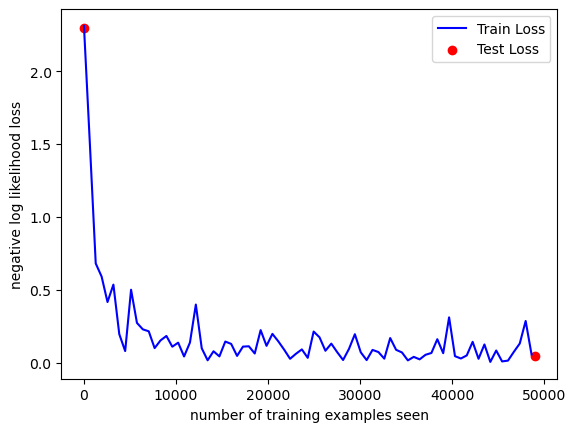

In [30]:
# Plot the loss curve to see how the loss is decreasing with each mini batch

fig = plt.figure() # create a figure object
plt.plot(train_counter, train_losses, color='blue') # plot the train counter and the train losses in blue
plt.scatter(test_counter, test_losses, color='red') # plot the test counter and the test losses in red
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')  # create a legend for the plot
plt.xlabel('number of training examples seen') # label the x axis
plt.ylabel('negative log likelihood loss') # label the y axis

In [31]:
# Function to predict on new images from trained model

read_in_images = []  # To store the images read in

def classify(model,image,classes,count): # send a model, an image, the classes, and the count of the image
    # Preprocess the image to make it the same type of image the model was trained on (remove color images with multiple channels, resize the image to 28x28, convert to grayscale if necessary)
    image = io.imread(image) # read in the image
    print(image.shape) # print the shape of the image
    read_in_images.append(image) # append the image to the read in images list
    io.imshow(read_in_images[count]) # display the image
    plt.show() # show the image
    count += 1 # increment the count
    
    # Transform to correct shape
    image = transform.resize(image,(28,28)) # resize the image to 28x28
    
    # Check if image has more than 2 channels (RGB type) and if yes convert to grayscale
    if len(image.shape) > 2: # for example, if the image has 3 channels
        image = rgb2gray(image) # convert the image to grayscale
    print(image.shape) # print the shape of the image
    #image = image/255
    
    # Put in eval mode
    model = model.eval() # set the model to evaluation mode
    image = torch.from_numpy(image) # Convert to torch tensor
    image = image.float() # of type float
    
    image = image.unsqueeze(0) # since it is a single batch, add an additional dimension 1 to the 0th column (1,28,28)
    
    # Predict
    output = model(image) # send the image to the model to predict and get the output
    print(f"Predictions:\n{output.data}\n") # print the output data
    
    # Pick the value with the highes probability score in the output
    _,predicted = torch.max(output.data,1) # take the maximum value of the output data and the index of the maximum value
    print(f"Predicted Number:{classes[predicted.item()]}\n") # the maximum value is the predicted value

(224, 225, 3)


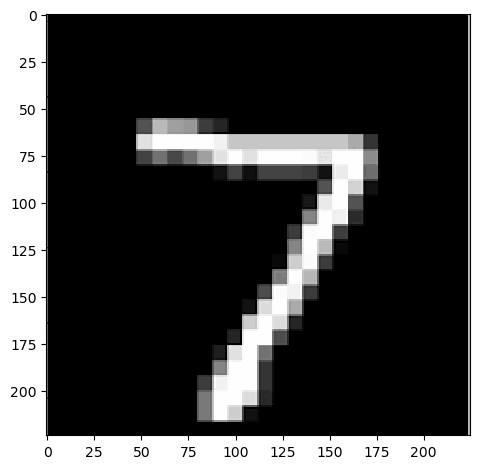

(28, 28)
Predictions:
tensor([[-2.9711, -0.0645, -1.5772,  3.9525, -1.8744, -1.9147, -5.9468, 10.6986,
         -2.4706, -0.7262]])

Predicted Number:7

(28, 28)


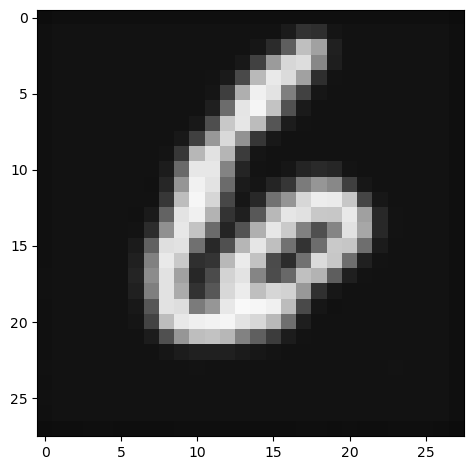

(28, 28)
Predictions:
tensor([[ 1.4166, -0.4875, -1.6249, -2.7382,  1.8274,  2.2910,  9.2995, -1.8014,
          0.7999, -0.6795]])

Predicted Number:6



In [33]:
# Feed new unseen images

pics = ['7.png','nr6.png'] # download 2 images from the internet and put them in the same directory as the notebook

count = 0 # initialize the counter to 0

# Define the classes
classes = [0,1,2,3,4,5,6,7,8,9] # define the classes which are the digits 0-9

# Call the prediction function
for i in pics: # pick the images one by one
    classify(model,i,classes,count) # call the classify function to classify the image
    count += 1 # increment the count by 1

'''
Preprocessing:
We reduced the 7.png from 224x225x3 to 28x28.
The nr6.png was already 28x28.

Predictions:
We show the number 7 image and the model predicts the number 7 correctly. 
We show the number 6 image and the model predicts the number 6 correctly.
'''